In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
columns = [
    'neighbourhood_group', 'room_type', 'latitude', 'longitude',
    'minimum_nights', 'number_of_reviews','reviews_per_month',
    'calculated_host_listings_count', 'availability_365',
    'price'
]

df = pd.read_csv('AB_NYC_2019.csv', usecols=columns)
df.reviews_per_month = df.reviews_per_month.fillna(0)

In [3]:
from sklearn.model_selection import train_test_split

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [4]:
y_train = np.log1p(df_train.price.values)
y_test = np.log1p(df_test.price.values)
y_val = np.log1p(df_val.price.values)

In [5]:
del df_train['price']
del df_val['price']
del df_test['price']

In [6]:
from sklearn.feature_extraction import DictVectorizer

In [7]:
numerical = ['latitude', 'longitude', 'minimum_nights','number_of_reviews','reviews_per_month','calculated_host_listings_count','availability_365']

In [8]:
categorical=['neighbourhood_group','room_type']

In [9]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

In [11]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score
from sklearn.tree import export_text

In [12]:
train_dicts = df_train.fillna(0).to_dict(orient='records')

In [13]:
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)

In [21]:
train_above_average = (y_train >= 4.7389).astype(int)

In [22]:
train_above_average.mean()

0.47724716228653236

In [20]:
y_train.mean()

4.738904794108825

In [23]:
test_above_average = (y_test >= 4.7389).astype(int)
val_above_average = (y_val >= 4.7389).astype(int)

In [24]:
dt = DecisionTreeClassifier()
dt.fit(X_train, train_above_average)

DecisionTreeClassifier()

In [25]:
val_dicts = df_val.fillna(0).to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [26]:
y_pred = dt.predict_proba(X_val)[:, 1]
roc_auc_score(val_above_average, y_pred)

0.7761279958189236

In [27]:
y_pred = dt.predict_proba(X_train)[:, 1]
roc_auc_score(train_above_average, y_pred)

1.0

In [28]:
dt = DecisionTreeClassifier(max_depth=1)
dt.fit(X_train, train_above_average)

DecisionTreeClassifier(max_depth=1)

In [29]:
y_pred = dt.predict_proba(X_train)[:, 1]
auc = roc_auc_score(train_above_average, y_pred)
print('train:', auc)

y_pred = dt.predict_proba(X_val)[:, 1]
auc = roc_auc_score(val_above_average, y_pred)
print('val:', auc)

train: 0.816299213034079
val: 0.8207601229834918


In [30]:
print(export_text(dt, feature_names=dv.get_feature_names()))

|--- room_type=Entire home/apt <= 0.50
|   |--- class: 0
|--- room_type=Entire home/apt >  0.50
|   |--- class: 1



In [31]:
from sklearn.ensemble import RandomForestClassifier

In [45]:
scores = []

for n in range(10, 201, 10):
    rf = RandomForestClassifier(n_estimators=n, random_state=1, n_jobs=-1)
    rf.fit(X_train, train_above_average)

    y_pred = rf.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(val_above_average, y_pred)
    rmse = np.sqrt(metrics.mean_squared_error(val_above_average, y_pred))
    
    scores.append((n, auc, rmse))

In [37]:
df_scores = pd.DataFrame(scores, columns=['n_estimators', 'auc'])

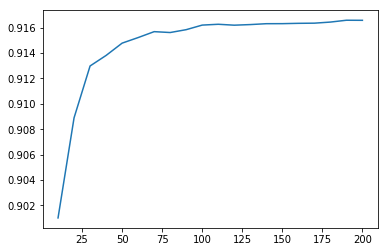

In [38]:
plt.plot(df_scores.n_estimators, df_scores.auc)

In [39]:
from sklearn import metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(test_above_average, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(test_above_average, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(test_above_average, y_pred)))

Mean Absolute Error: 0.49554760200429493
Mean Squared Error: 0.386465533285612
Root Mean Squared Error: 0.621663520954553


In [40]:
print('Mean Absolute Error:', metrics.mean_absolute_error(val_above_average, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(val_above_average, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(val_above_average, y_pred)))

Mean Absolute Error: 0.22355251048164432
Mean Squared Error: 0.11447044176296144
Root Mean Squared Error: 0.3383348071998526


In [46]:
scores

[(10, 0.9010120132148047, 0.35179262779463044),
 (20, 0.9089010107343032, 0.345402436045933),
 (30, 0.9129873848161915, 0.34205915475385545),
 (40, 0.9138173564989925, 0.3411746332619552),
 (50, 0.9147868763041753, 0.34015816536121574),
 (60, 0.9152257945647013, 0.3397363678983576),
 (70, 0.9156918215575348, 0.3393891213908903),
 (80, 0.9156231586818137, 0.3392782599920626),
 (90, 0.9158481003592525, 0.3391573639107798),
 (100, 0.9162087743901016, 0.338881632452969),
 (110, 0.9162733279761615, 0.3387150342916775),
 (120, 0.9162015621674306, 0.33880141298252653),
 (130, 0.9162493012110999, 0.3387804589008515),
 (140, 0.9163187188543098, 0.3387597077259393),
 (150, 0.9163218637188467, 0.3387465222687996),
 (160, 0.9163479241629755, 0.3386922052297981),
 (170, 0.9163605245868864, 0.33865708616025214),
 (180, 0.9164465471148511, 0.3386112390525296),
 (190, 0.9165909383286195, 0.33839011580554657),
 (200, 0.9165855501273795, 0.3383348071998526)]

In [48]:
scores = []

for d in [10, 15, 20, 25]:
    for n in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=n,
                                    max_depth=d,
                                    random_state=1)
        rf.fit(X_train, train_above_average)

        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(val_above_average, y_pred)

        scores.append((d, n, auc))

In [49]:
columns = ['max_depth', 'n_estimators', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)

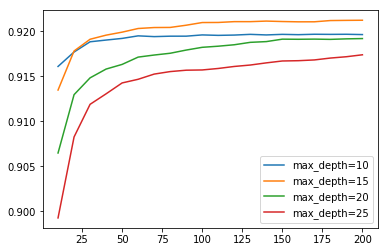

In [50]:

for d in [10, 15, 20, 25]:
    df_subset = df_scores[df_scores.max_depth == d]
    
    plt.plot(df_subset.n_estimators, df_subset.auc,
             label='max_depth=%d' % d)

plt.legend()

In [51]:
rf = RandomForestClassifier(n_estimators=10,
                            max_depth=20,
                            n_jobs=-1,
                            random_state=1)
rf.fit(X_train, train_above_average)

RandomForestClassifier(max_depth=20, n_estimators=10, n_jobs=-1, random_state=1)

In [54]:
rf.feature_importances_

array([0.0699863 , 0.03069858, 0.12998662, 0.1408855 , 0.04631846,
       0.00168829, 0.00890011, 0.03651349, 0.0075344 , 0.00091645,
       0.05382494, 0.06588743, 0.20123564, 0.19284581, 0.01277798])

In [62]:
t1 = zip(X_train.columns, rf.feature_importances_)


AttributeError: 'numpy.ndarray' object has no attribute 'columns'

In [58]:
X_train

array([[363.     ,   1.     ,  40.76434, ...,   1.     ,   0.     ,
          0.     ],
       [  0.     ,   1.     ,  40.73442, ...,   0.     ,   1.     ,
          0.     ],
       [113.     ,   5.     ,  40.66359, ...,   1.     ,   0.     ,
          0.     ],
       ...,
       [178.     ,   2.     ,  40.69034, ...,   0.     ,   1.     ,
          0.     ],
       [  0.     ,   1.     ,  40.76324, ...,   1.     ,   0.     ,
          0.     ],
       [362.     ,  23.     ,  40.74563, ...,   1.     ,   0.     ,
          0.     ]])

In [60]:
train_dicts

[{'neighbourhood_group': 'Queens',
  'latitude': 40.764340000000004,
  'longitude': -73.92132,
  'room_type': 'Entire home/apt',
  'minimum_nights': 4,
  'number_of_reviews': 30,
  'reviews_per_month': 0.32,
  'calculated_host_listings_count': 1,
  'availability_365': 363},
 {'neighbourhood_group': 'Brooklyn',
  'latitude': 40.73442,
  'longitude': -73.95854,
  'room_type': 'Private room',
  'minimum_nights': 5,
  'number_of_reviews': 2,
  'reviews_per_month': 0.16,
  'calculated_host_listings_count': 1,
  'availability_365': 0},
 {'neighbourhood_group': 'Brooklyn',
  'latitude': 40.66359,
  'longitude': -73.99486999999999,
  'room_type': 'Entire home/apt',
  'minimum_nights': 1,
  'number_of_reviews': 33,
  'reviews_per_month': 2.75,
  'calculated_host_listings_count': 5,
  'availability_365': 113},
 {'neighbourhood_group': 'Brooklyn',
  'latitude': 40.63766,
  'longitude': -74.02626,
  'room_type': 'Private room',
  'minimum_nights': 3,
  'number_of_reviews': 1,
  'reviews_per_month'